In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import sys
import math
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eig
import sys
from random import seed
import pandas as pd
import cvxpy as cp
import random

np.random.seed(1)
seed(1)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
#creating a random dataset with the equation of a line
def generate_data_straightline(dim_x=1,start=-10,end=10,isNoise=True,isConstant=True,n = 10):
    print("GENERATING DATA")
    X = np.random.uniform(start,end,(n, dim_x))
    W = np.random.randint(1,10,(dim_x, ))
    noise = np.random.uniform(-0.5, 0.0, n)
    if(isNoise):
      noise = np.random.uniform(-0.5, 0.0, (n, dim_x))
      X=X+noise
    b=0
    if(isConstant):
      b=np.random.randint(1,500)
    y=np.dot(X,W)
    print("X = ", X.shape, " y = ", y.shape)
    print("Equation of line is ")
    print(W)
    print("constant is "+str(b))
    return X, y

In [4]:
# converting regression to classification problem
def getClassification(X,Y,eph=1):
  N=X.shape[0]
  Xpos=np.append(X,(Y+eph).reshape(-1,1),axis=1)
  Xneg=np.append(X,(Y-eph).reshape(-1,1),axis=1)
  Ypos=np.ones(N)
  Yneg=np.ones(N)*-1
  return np.append(Xpos,Xneg,axis=0),np.append(Ypos,Yneg,axis=0)


In [5]:
# primal solver for SVM
def inner_prod_cp(w,x):
    return cp.sum(cp.multiply(w,x))
def SVM_OPT(X,Y,C=1000000,restrictions_on_weight=False):
  M=X.shape[0]
  d=X.shape[1]
  w = cp.Variable(d)
  qi = cp.Variable(M)
  obj=cp.Minimize((1/2)*cp.norm2(w) + cp.sum(qi)*C)
  constraints=[]
  for i in range(M):
    constraints+=[cp.multiply(Y[i],(inner_prod_cp(w,X[i])))+qi[i]>=1,qi[i]>=0]
  max_X=np.max(X,axis=0)
  min_X=np.min(X,axis=0)
  if restrictions_on_weight:
    for i in range(d):
      constraints+=[w[i]<max_X[i]]
      constraints+=[w[i]>min_X[i]]
  problem = cp.Problem(obj,constraints)
  problem.solve()
  return w.value

In [6]:
#generating data 
#equation of the line will be printed
X,Y=generate_data_straightline(dim_x=2,isNoise=False,isConstant=False,n=100)

GENERATING DATA
X =  (100, 2)  y =  (100,)
Equation of line is 
[6 5]
constant is 0


In [7]:
#converting to classification
X_class,Y_class=getClassification(X,Y)

In [8]:
X_class.shape

(200, 3)

In [9]:
Y_class

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

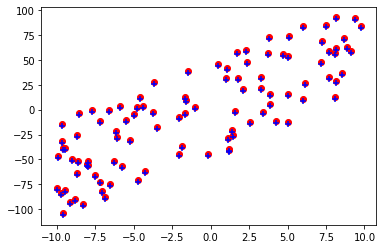

In [10]:
  # plotting the data
  X_mn_pca=X_class
  Y_SVM=Y_class
  plt.scatter(X_mn_pca[Y_SVM.reshape(-1) == 1, 0], X_mn_pca[Y_SVM.reshape(-1) == 1, 2], marker='o', facecolors='r', edgecolors='r')
  plt.scatter(X_mn_pca[Y_SVM.reshape(-1) == -1, 0], X_mn_pca[Y_SVM.reshape(-1) == -1, 2], marker='+', facecolors='b', edgecolors='b')

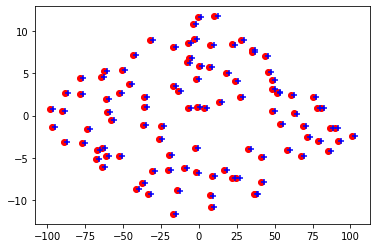

In [9]:
  X_mn_pca=X_class
  Y_SVM=Y_class
  pca = PCA(n_components=2)
  X_mn_pca = pca.fit_transform(X_mn_pca)
  plt.scatter(X_mn_pca[Y_SVM.reshape(-1) == 1, 0], X_mn_pca[Y_SVM.reshape(-1) == 1, 1], marker='o', facecolors='r', edgecolors='r')
  plt.scatter(X_mn_pca[Y_SVM.reshape(-1) == -1, 0], X_mn_pca[Y_SVM.reshape(-1) == -1, 1], marker='+', facecolors='b', edgecolors='b')

In [11]:
#Running classification on converted Classification problem
append_one=True
if append_one:
  X_class=np.append(np.ones(X_class.shape[0]).reshape(-1,1),X_class,axis=1)

In [12]:
W=SVM_OPT(X_class,Y_class)

In [13]:
#weights printed middle values are the equation of the line
#W[0] is b
#W[-1] is weight corresponding to Y value should be 1 for a good fit
W

array([ 5.31353903e-14, -6.00000000e+00, -5.00000000e+00,  1.00000000e+00])